# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 27 января 23:59

**Продуктивной и интересной вам работы!**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/ML-AI-HSE/HW/HW_04/')

In [3]:
!pip install optuna -q
!pip install lime -q
!pip install shap -q
!pip install psycopg2-binary -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [6]:
from hw4_code_pro import find_best_split

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [7]:
data_url = 'https://raw.githubusercontent.com/AnastasiyaMax/MLDS_ml_course_fall21/refs/heads/main/hw/hw5_trees/students.csv'
data = pd.read_csv(data_url)
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [8]:
def get_cmap(n, name='hsv'):
    """
    Функция для генерации различных цветов.
    """
    return plt.cm.get_cmap(name, n)

Отображение кривых "порог — значение критерия Джини" для всех признаков:

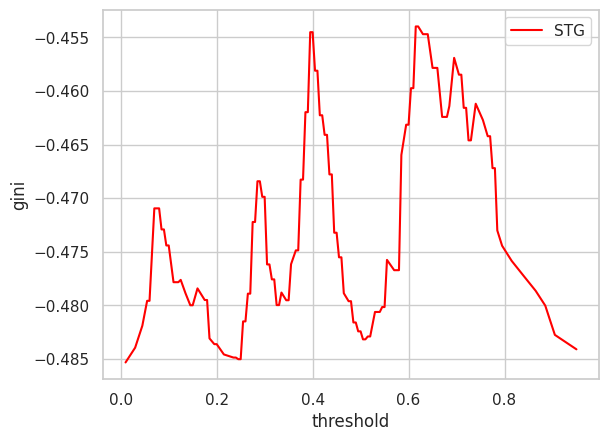

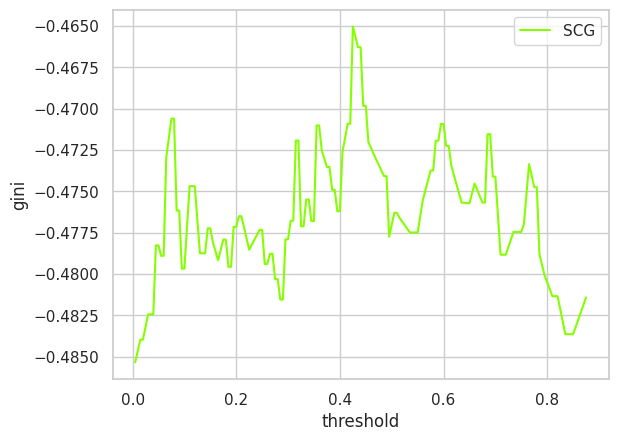

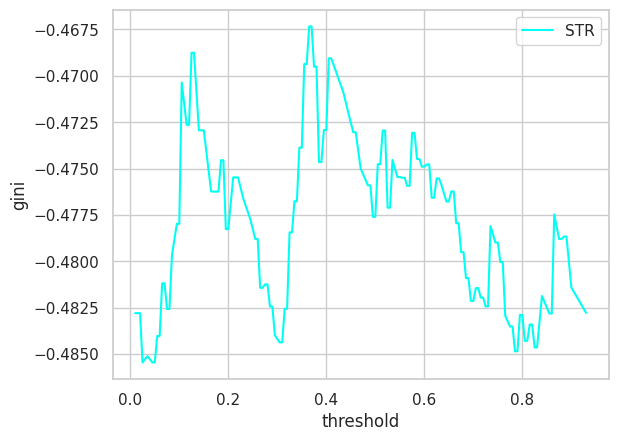

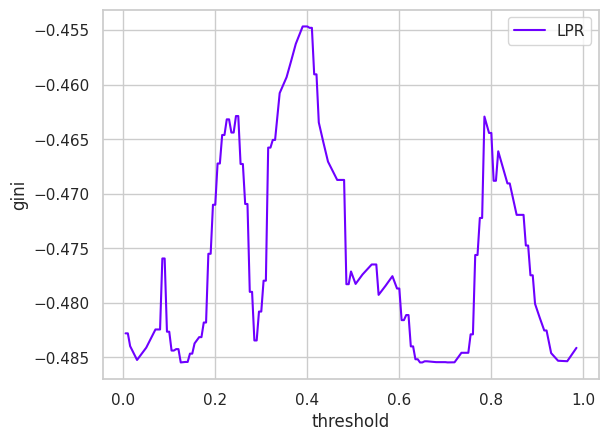

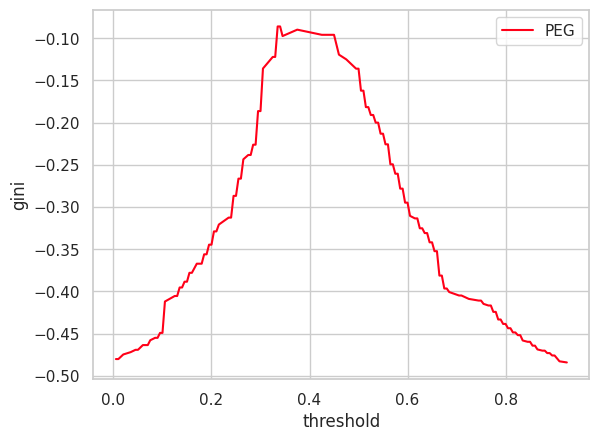

In [9]:
target_column_name = 'UNS'
target_vector = data[target_column_name].to_numpy()
cmap = get_cmap(len(data.columns) - 1)
for i, column in enumerate(data.columns[:-1]):
    feature_vector = data[column].to_numpy()

    thresholds, ginis, _, _ = find_best_split(feature_vector, target_vector)
    plt.plot(thresholds, ginis, color=cmap(i), label=column)
    plt.xlabel('threshold')
    plt.ylabel('gini')
    plt.legend()
    plt.show()

Отображение кривых "признак — класс" для всех признаков:

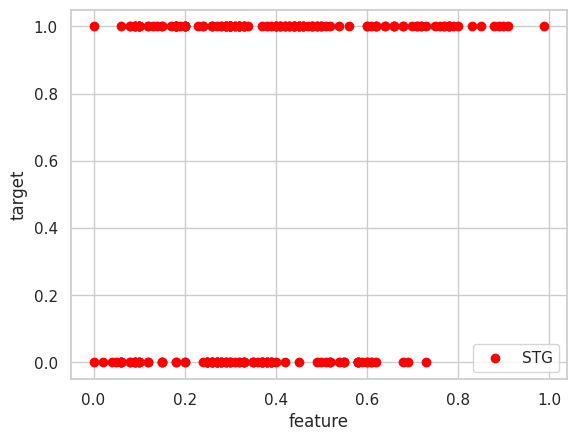

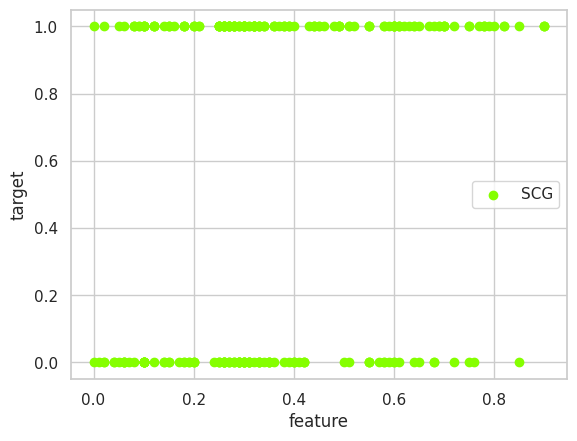

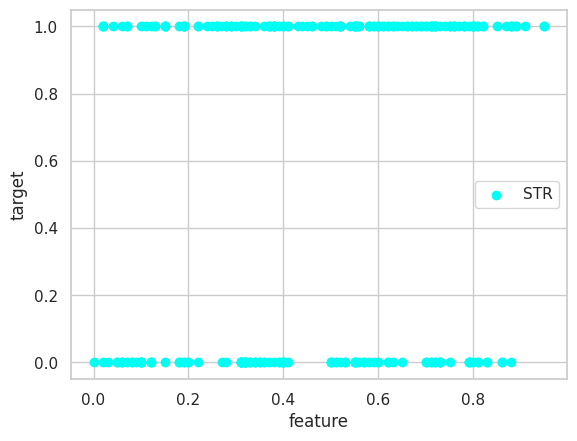

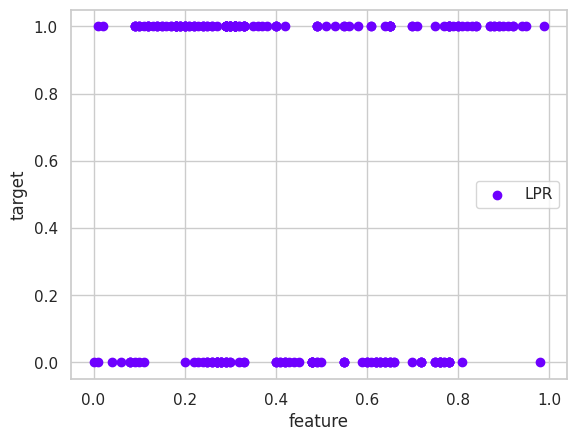

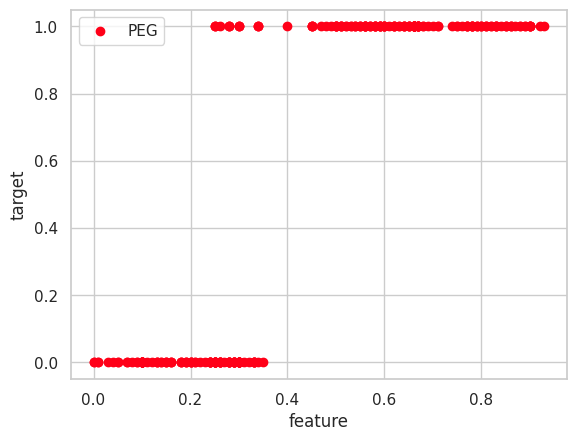

In [10]:
for i, column in enumerate(data.columns[:-1]):
    plt.scatter(data=data, x=column, y=target_column_name, color=cmap(i), label=column)
    plt.xlabel('feature')
    plt.ylabel('target')
    plt.legend()
    plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**<br>
-`Судя по графикам стоит делить по признаку 'PEG', так как при нем наблюдается самый высокий показатель прироста информации. В целом это видно из scatter plot: классы практически идеально можно разделить по порогу 0.4, поэтому IG почти равен 0.`<br>
-`Для хороших признаков кривая будет иметь вид перевернутой параболы, значение которой будет приближаться к 0 (где выборка будет идеально разделима).`
-`Кажется, что кривые для плохих признаков могут иметь любую форму, однако у них будет кое-что общее: значение этих кривых будет далеко от 0. Это говорит о том, что данные нельзя нормально разделить.`

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


In [11]:
from hw4_code_pro import DecisionTree

### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
!pip install ucimlrepo -q

Загружаем датасет mushrooms:

In [13]:
from ucimlrepo import fetch_ucirepo

mushroom_data = fetch_ucirepo(id=73)

X_mushroom = mushroom_data.data.features
y_mushroom = mushroom_data.data.targets

y_mushroom = y_mushroom.iloc[:,0].apply(lambda x: 1 if x == 'e' else 0).values

In [14]:
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X = X_mushroom.apply(encoder.fit_transform)

In [16]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.5

X_train, X_test, y_train, y_test = train_test_split(X.values, y_mushroom, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [17]:
dt = DecisionTree(feature_types=['real'] * X.shape[1])
dt.fit(X_train, y_train)

In [18]:
from sklearn.metrics import accuracy_score

test_pred = dt.predict(X_test)
accuracy_score(y_test, test_pred)

0.9945839487936977

### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [19]:
tic_tac_toe_endgame = fetch_ucirepo(id=101)

X_tic_tac_toe = tic_tac_toe_endgame.data.features
y_tic_tac_toe = tic_tac_toe_endgame.data.targets

y_tic_tac_toe = y_tic_tac_toe.iloc[:,0].apply(lambda x: 1 if x == 'positive' else 0).values

In [20]:
TEST_SIZE = 0.5

X_train, X_test, y_train, y_test = train_test_split(X_tic_tac_toe.values, y_tic_tac_toe, test_size=TEST_SIZE, random_state=RANDOM_SEED)

Посмотрим на качество модели без подбора гиперпараметров:

In [21]:
dt = DecisionTree(feature_types=['categorical'] * X.shape[1])
dt.fit(X_train, y_train)

test_pred = dt.predict(X_test)
accuracy_score(y_test, test_pred)

0.9206680584551148

Теперь посмотрим на то как влияют гиперпараметры max_depth, min_sample_split и min_sample_leaf по отдельности.

Best accuracy for max_depth = 7: 0.9269
Best accuracy for min_samples_split = 4: 0.929
Best accuracy for min_samples_leaf = 6: 0.9374


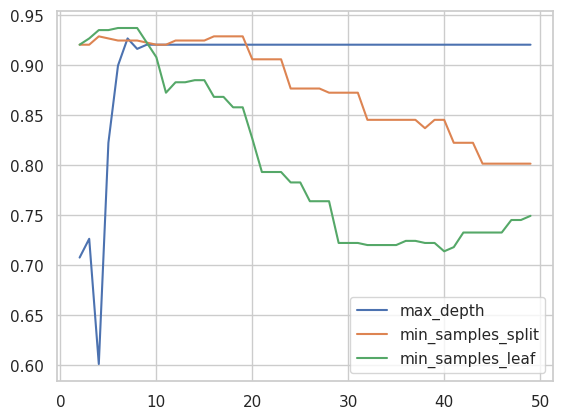

In [23]:
params = {
    'max_depth': np.arange(2, 50),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(2, 50)
}

for param in params:
    acc_lst = []
    for param_value in params[param]:
        dt = DecisionTree(feature_types=['categorical'] * X.shape[1], **{param: param_value})
        dt.fit(X_train, y_train)

        test_pred = dt.predict(X_test)
        acc_lst += [accuracy_score(y_test, test_pred)]
    best_acc_indx = np.argmax(acc_lst)
    best_param = params[param][best_acc_indx]
    print(f'Best accuracy for {param} = {best_param}: {round(acc_lst[best_acc_indx], 4)}')
    plt.plot(params[param], acc_lst, label=param)
    plt.legend()

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

Загружаем остальные датасеты:

In [22]:
cars_dataset = fetch_ucirepo(id=19)
X_cars = cars_dataset.data.features
y_cars = cars_dataset.data.targets
y_cars = y_cars.iloc[:,0].apply(lambda x: 1 if x in ['good', 'vgood'] else 0).values

nursery_dataset = fetch_ucirepo(id=76)
X_nursery = nursery_dataset.data.features
y_nursery = nursery_dataset.data.targets
y_nursery = y_nursery.iloc[:,0].apply(lambda x: 1 if x in ['very_recom', 'priority', 'spec_prior'] else 0).values

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

In [43]:
datasets = [
    ('mushrooms', X_mushroom, y_mushroom),
    ('tic-tac-toe', X_tic_tac_toe, y_tic_tac_toe),
    ('cars', X_cars, y_cars),
    ('nursery', X_nursery, y_nursery)
]
N_FOLDS = 10
results = pd.DataFrame(columns=['dataset', 'dt_real', 'dt_cat', 'dt_cat_real', 'dt_sklearn'])

for i, (dataset_name, X, y) in enumerate(tqdm(datasets)):
    dt1 = DecisionTree(feature_types=['real'] * X.shape[1])
    X_1 = X.apply(LabelEncoder().fit_transform).values
    cv1 = cross_val_score(dt1, X_1, y, cv=N_FOLDS, scoring=make_scorer(accuracy_score)).mean()

    dt2 = DecisionTree(feature_types=['categorical'] * X.shape[1])
    cv2 = cross_val_score(dt2, X.values, y, cv=N_FOLDS, scoring=make_scorer(accuracy_score)).mean()

    ohe = OneHotEncoder(sparse_output=False)
    X_3 = ohe.fit_transform(X)
    dt3 = DecisionTree(feature_types=['real'] * X_3.shape[1])
    cv3 = cross_val_score(dt3, X_3, y, cv=N_FOLDS, scoring=make_scorer(accuracy_score)).mean()

    dt4 = DecisionTreeClassifier()
    cv4 = cross_val_score(dt4, X_1, y, cv=N_FOLDS, scoring=make_scorer(accuracy_score)).mean()

    results.loc[i] = [dataset_name, cv1, cv2, cv3, cv4]

100%|██████████| 4/4 [11:37<00:00, 174.30s/it]


In [44]:
results

,dataset,dt_real,dt_cat,dt_cat_real,dt_sklearn
0,mushrooms,0.987563,0.998522,0.993843,0.956689
1,tic-tac-toe,0.401798,0.551886,0.548750,0.756064
2,cars,0.938580,0.957689,0.921223,0.943285
3,nursery,0.966281,0.966049,0.966049,0.999691


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**<br>
`- Для разных наборов данных алгоритмы ранжируются по разному. Например, для mushrooms dt_real оказался лучше, чем DT из sklearn, хотя для датасета tic-tac-toe это не так. Думаю, причина может быть в том, что деревья склонны к переобучению, поэтому мы видит тут такую картину. Тем более, мы не подбирали гиперпараметры.`<br>
`- Если я правильно понял вопрос, то для первых трех моделей никакой случайности нет (т.к. модель кастомная и в нее не была заложена случайность). Однако, в модели DT из sklearn эта случайность есть. Улучшить работу этого дерева можно, если попробовать перебрать разные random_state, но это будет нечестно, поэтому так делать не надо.`

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [24]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-14 10:51:34--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-14 10:51:36 (1.63 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

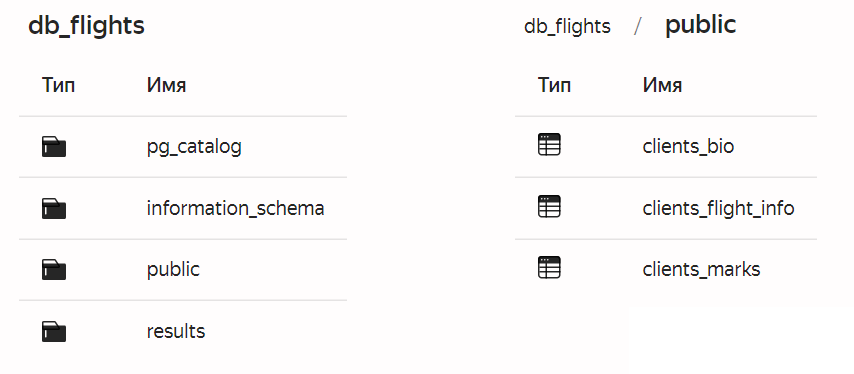

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
                        port=6432,
                        sslmode='verify-full',
                        dbname='db_flights',
                        user='mlhs_student',
                        password='mlhs_student',
                        target_session_attrs='read-write')
cursor = conn.cursor()

In [27]:
cursor.execute("""SELECT * FROM clients_bio
                  JOIN clients_flight_info ON clients_bio.id=clients_flight_info.id
                  JOIN clients_marks ON clients_marks.id=clients_bio.id""")
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data=cursor.fetchall(), columns=column_names)
df = df.T.drop_duplicates().T
df = df.set_index('id')
df.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [28]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [29]:
df_train = df[df.satisfaction != '-']

df_train.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [30]:
assert df_train.shape == (103_644, 23)

In [31]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,0.0,3.0,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,2.0,4.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,4.0,4.0,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0


In [32]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [34]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

Преобразование числовых столбцов в float:

In [35]:
num_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',	'Inflight wifi service',
            'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink',
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
            'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']

for num_col in num_cols:
    X_train[num_col] = X_train[num_col].astype(float)
    X_val[num_col] = X_val[num_col].astype(float)
    df_test[num_col] = df_test[num_col].astype(float)

Количество пропусков:

In [36]:
# Категориальные столбцы могут иметь строковое значение 'nan',
# которое нужно заменить.
for cat_col in ['gender', 'Customer Type', 'Type of Travel', 'class']:
    X_train[cat_col] = X_train[cat_col].replace('nan', None)
    X_val[cat_col] = X_val[cat_col].replace('nan', None)
    df_test[cat_col] = df_test[cat_col].replace('nan', None)

pd.concat([X_train.isna().sum(), X_val.isna().sum(), df_test.isna().sum()], axis=1).T

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
0,0,185,52,70,66,54,61,294,23,28,24,19,22,23,23,30,23,22,21,22,30,21
1,0,76,14,18,23,18,23,111,9,13,9,11,13,14,18,12,9,14,11,12,19,10
2,0,54,11,13,27,22,23,102,12,8,10,7,15,9,6,3,12,10,16,8,14,6


Заполняем пропуски:

In [37]:
train_mode = X_train.mode()
X_train = X_train.fillna(train_mode.iloc[0])
X_val = X_val.fillna(train_mode.iloc[0])
df_test = df_test.fillna(train_mode.iloc[0])

Количество пропусков после заполнения:

In [38]:
X_train.isna().sum().sum() + X_val.isna().sum().sum() + df_test.isna().sum().sum()

0

In [39]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,40.098856,1329.018332,15.859366,16.645968,2.733687,3.065017,2.761006,2.982688,3.209318,3.256513,3.445665,3.362150,3.383101,3.352364,3.630255,3.309056,3.640234,3.291178
std,20.658196,4764.369357,70.861937,97.990293,1.362172,1.552254,1.414843,1.316648,1.349963,1.372739,1.346077,1.360862,1.333758,1.360180,1.227853,1.293114,1.215114,1.343302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


Кажется, что есть вопросы к признаку age, так как максимальный возраст равен 544. Давайте попробуем это исправить, но уже в следующем задании, так как оно посвящено предобработке.

In [40]:
X_train.describe(include=[object])

,gender,Customer Type,Type of Travel,class
count,72550,72550,72550,72550
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59406,50054,34793


`- Некоторые из признаков имеют очень большое среднее по сравнению с другими, поэтому в сладеющем разделе стоит отнормировать данные.`<br>
`- Надо удалить выбросы из данных, как минимум у столбца age, возможно еще где-нибудь.`<br>
`- В основном в данных встречаются "лояльные" клиенты. Также, бизнес поездок было больше, чем персональных.`

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

In [41]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0).values
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0).values

`Начнем с того, что попробуем удалить выбросы. Из таблицы describe очевидно, что надо удалить выбросы по признаку age. Остальные фичи, вроде, трогать не надо.`

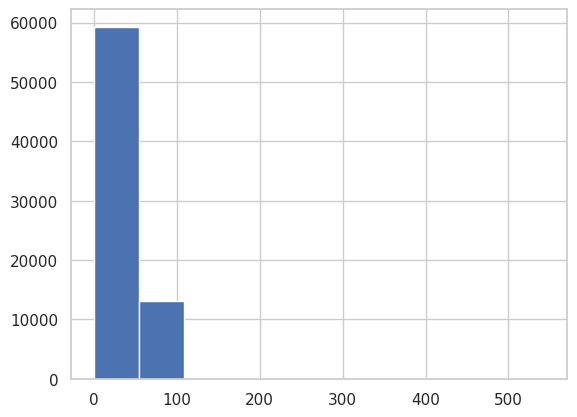

In [42]:
plt.hist(X_train['age']);

`Думаю будет достаточно удаления клиентов, возраст которых превышает 100.`

In [43]:
X_train = X_train[X_train['age'] < 100]
y_train = y_train[np.where(X_train['age'] < 100)[0]]
X_val = X_val[X_val['age'] < 100]
y_val = y_val[np.where(X_val['age'] < 100)[0]]
df_test = df_test[df_test['age'] < 100]

`У нас есть категориальные признаки, попробуем их закодировать. Так как уникальных значений признаков в районе 2-3, то можно смело пользоваться OneHotEncoder. Столбец class можно закодировать как порядковый признак, т.е. числами 1, 2, ...`.

In [44]:
# Кодируем признак class.
X_train['class'] = X_train['class'].map({'Eco': 1, 'Eco Plus': 2, 'Business': 3})
X_val['class'] = X_val['class'].map({'Eco': 1, 'Eco Plus': 2, 'Business': 3})
df_test['class'] = df_test['class'].map({'Eco': 1, 'Eco Plus': 2, 'Business': 3})

In [45]:
num_cols = X_train._get_numeric_data().columns
cols = X_train.columns
cat_cols = list(set(cols) - set(num_cols))

`Кодируем оставшиеся признаки с помощью OneHotEncoder.`

In [46]:
X_train_num = X_train[num_cols].reset_index()
X_train_cat = X_train[cat_cols]

ohe = OneHotEncoder(sparse_output=False)
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train_cat))
X_train = pd.concat([X_train_num, X_train_cat], axis=1)

X_val_num = X_val[num_cols].reset_index()
X_val_cat = X_val[cat_cols]

X_val_cat = pd.DataFrame(ohe.transform(X_val_cat))
X_val = pd.concat([X_val_num, X_val_cat], axis=1)

df_test_num = df_test[num_cols].reset_index()
df_test_cat = df_test[cat_cols]

df_test_cat = pd.DataFrame(ohe.transform(df_test_cat))
df_test = pd.concat([df_test_num, df_test_cat], axis=1)

In [47]:
assert X_train.shape[1] == X_val.shape[1] == df_test.shape[1]

Наконец, попробуем отнормировать все признаки.

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.values)

X_train = scaler.transform(X_train.values)
X_val = scaler.transform(X_val.values)
df_test = scaler.transform(df_test.values)

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [49]:
from sklearn.metrics import f1_score

Обучение DecisionTree:

In [419]:
dt = DecisionTree(feature_types=['real'] * X_train.shape[1])
dt.fit(X_train, y_train)

val_pred = dt.predict(X_val)
f1_score(y_val, val_pred, average='weighted')

0.5073341575757019

Обучение RandomForest:

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

val_pred = rf.predict(X_val)
f1_score(y_val, val_pred, average='weighted')

0.49422102852579874

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

`Гиперпараметры для дерева не буду подбирать, потому что оно обучается где-то час :)`

In [55]:
rf = RandomForestClassifier(random_state=RANDOM_SEED)
distributions = dict(
    max_features=uniform(loc=0, scale=1),
    min_samples_leaf=[2, 5],
    min_samples_split=[2, 5, 10, 20, 30],
    n_estimators=[10, 50, 100, 200, 300]
    )
clf = RandomizedSearchCV(rf, distributions, random_state=RANDOM_SEED, scoring='f1_weighted', cv=3, verbose=3)
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_features=0.3745401188473625, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.475 total time= 1.3min
[CV 2/3] END max_features=0.3745401188473625, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.472 total time= 1.3min
[CV 3/3] END max_features=0.3745401188473625, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.475 total time= 1.3min
[CV 1/3] END max_features=0.596850157946487, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.482 total time=  40.6s
[CV 2/3] END max_features=0.596850157946487, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.481 total time=  37.4s
[CV 3/3] END max_features=0.596850157946487, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.482 total time=  38.5s
[CV 1/3] END max_features=0.45924889196586716, min_samples_leaf=2, min_samples_split=20, n_estimators=100;, score=

{'max_features': 0.6116531604882809,
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 10}

In [53]:
best_rf = RandomForestClassifier(max_features=0.611, min_samples_leaf=2, min_samples_split=20, n_estimators=10)
best_rf.fit(X_train, y_train)
val_pred = best_rf.predict(X_val)
f1_score(y_val, val_pred, average='weighted')

0.5073993416556092

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

<Axes: >

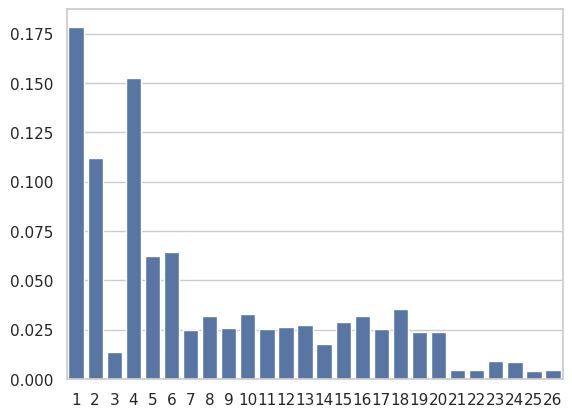

In [69]:
sns.barplot(x=range(1, 27), y=best_rf.feature_importances_)

`Из-за того, что некоторые признаки кодировались с помощью OneHotEncoding, тяжело анализировать важность каждого признака.`

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

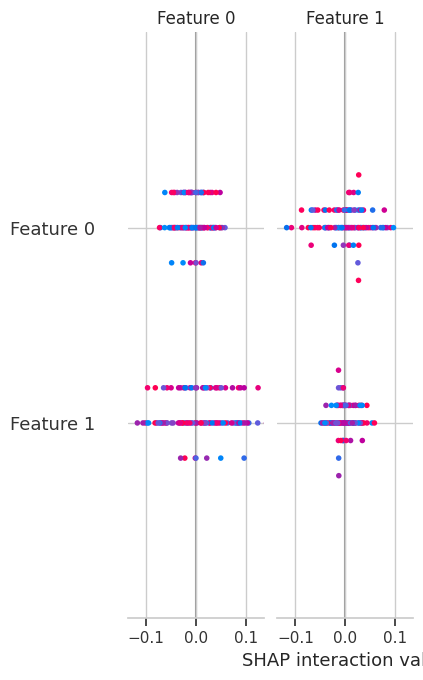

In [81]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train[:100])
shap.summary_plot(shap_values, X_train[:100])
plt.show()

`По какой-то причине отображаются только два признака`

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [84]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification')
explanation = explainer.explain_instance(X_train[0], best_rf.predict_proba, num_features=5)

explanation.show_in_notebook(show_table=True)

`Для первого наблюдения веротяность того, что клиент будет satisfied равна 0.57. В положительную сторону на это повлияли признаки 19, 0, 25 и 17. В отрицательную сторону повлиял признак 23.`

## Котобонус!

0.25 балла

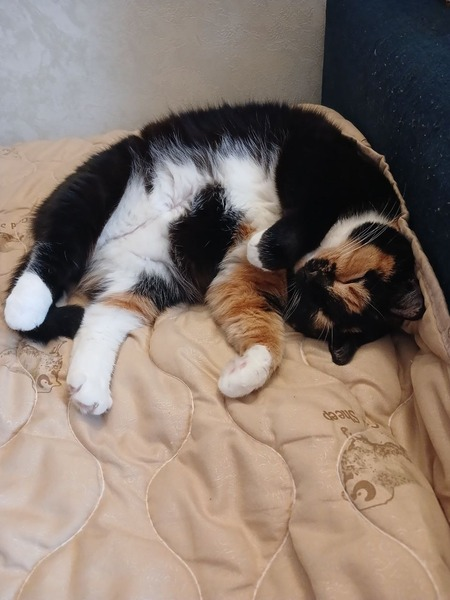

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?